In [1]:
!pip install pandas --quiet
!pip install torchtext --quiet

In [2]:
# We import some libraries to load the dataset
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import statistics

from collections import Counter
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import torchtext
from torchtext.data import get_tokenizer

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
#Change the path#
path = '/Users/bengieru/Desktop/NMA-DL/iSarcasm/iSarcasm_dataset/'
header_list = ["text", "label", 'source']
df_train_test = pd.read_csv(path + 'finaldata/train_test.csv', encoding = "utf-8", dtype = {'text':str, 'label':bool, 'source':int})
df_train_test.reset_index(drop=True, inplace=True)
del df_train_test['Unnamed: 0']
df_train_test = df_train_test.loc[df_train_test.text.apply(lambda x: not isinstance(x, (float, int)))]
df_train_test

,text,label,source
0,sorry sue mediweight advert look incredible go...,False,3
1,since fantasy individual time alive today,False,3
2,good time fun time grand old britannia,True,3
3,send light love impacted vegasshooting know lo...,False,3
4,another year closer death,False,3
...,...,...,...
3551,imagine going cost 600 pound travel university...,False,3
3552,people really tryna argue dont need soap sanitary,False,3
3553,relentless running game brink upsetting 7 know...,False,3
3554,whether get bed 645 715 always 731 kitchen clo...,False,3


In [4]:
# let's play with the lemmatized text to see how it's accuracy fairs
X = df_train_test.text.values
print(X.shape)
# Changes values from [0,4] to [0,1]
y = (df_train_test.label.values >= 1).astype(int)


# Split the data into train and test
x_train_text, x_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

(3544,)


In [5]:
for s, l in zip(x_train_text[:5], y_train[:5]):
    print('{}: {}'.format(l, s))

0: people still care lot leaked file sold public seen 2 leaked file tortured victim still waiting see leak journalist exposing nsa whistleblower karen stewart
0: good
1: magic money tree nurse one mp convenient
1: next train sure identifies train tram 🤦 🏻 ‍ ♀ ️
0: prince phillip personally visit woman house apologise accident


In [6]:
tokenizer = get_tokenizer("basic_english")
print('Before Tokenize: ', x_train_text[4])
print('After Tokenize: ', tokenizer(x_train_text[4]))

Before Tokenize:  prince phillip personally visit woman house apologise accident
After Tokenize:  ['prince', 'phillip', 'personally', 'visit', 'woman', 'house', 'apologise', 'accident']


In [7]:
x_train_token = [tokenizer(s) for s in tqdm(x_train_text)]
x_test_token = [tokenizer(s) for s in tqdm(x_test_text)]

  0%|          | 0/2835 [00:00<?, ?it/s]

  0%|          | 0/709 [00:00<?, ?it/s]

In [8]:
words = Counter()
for s in x_train_token:
    for w in s:
        words[w] += 1

sorted_words = list(words.keys())
sorted_words.sort(key=lambda w: words[w], reverse=True)
print(f"Number of different Tokens in our Dataset: {len(sorted_words)}")
print(sorted_words[:20])

Number of different Tokens in our Dataset: 8822
['n', 'like', 'get', 'im', 'one', 'day', 'time', 'love', 'people', 'year', 'good', 'dont', 'back', 'today', 'really', 'new', 'make', 'go', 'would', 'thing']


In [9]:
count_occurences = sum(words.values())

accumulated = 0
counter = 0

while accumulated < count_occurences * 0.8:
    accumulated += words[sorted_words[counter]]
    counter += 1

print(f"The {counter * 100 / len(words)}% most common words "
      f"account for the {accumulated * 100 / count_occurences}% of the occurrences")

The 35.34345953298572% most common words account for the 80.00538122624693% of the occurrences


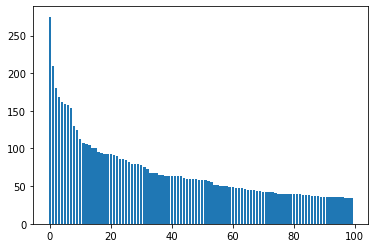

In [10]:
plt.bar(range(100), [words[w] for w in sorted_words[:100]])
plt.show()

In [11]:
vectorizer = CountVectorizer(binary=True)
x_train_cv = vectorizer.fit_transform(x_train_text)
x_test_cv = vectorizer.transform(x_test_text)

In [12]:
print('Before Vectorize: ', x_train_text[3])

Before Vectorize:  next train sure identifies train tram 🤦 🏻 ‍ ♀ ️


In [13]:
# Notice that the matriz is sparse
print('After Vectorize: ')
print(x_train_cv[3])

After Vectorize: 
  (0, 5091)	1
  (0, 7743)	1
  (0, 7356)	1
  (0, 3700)	1
  (0, 7749)	1


In [14]:
def set_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("WARNING: For this notebook to perform best, if possible, in the menu under `Runtime` -> `Change runtime type.`  select `GPU` ")
    else:
        print("GPU is enabled in this notebook.")

    return device

In [15]:
# Set the device (check if gpu is available)
device = set_device()
#First we will create a Dictionary (`word_to_idx`). 
#This dictionary will map each Token (usually words) to an index (an integer number). 
#We want to limit our dictionary to a certain number of tokens (`num_words_dict`), so we will include in our ditionary those with more occurrences.

In [16]:
#Change the path#
glove = pd.read_csv('/Users/bengieru/Downloads/glove/glove.twitter.27B.100d.txt', sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}

In [17]:
len(sorted_words)

8822

In [18]:
#Let's select only the most used.
num_words_dict = 6000
# We reserve two numbers for special tokens.
most_used_words = sorted_words[:num_words_dict-2]


#We will add two extra Tokens to the dictionary, one for words outside the dictionary (`'UNK'`) and one for padding the sequences (`'PAD'`).

# dictionary to go from words to idx 
word_to_idx = {}
# dictionary to go from idx to words (just in case) 
idx_to_word = {}


# We include the special tokens first
PAD_token = 0   
UNK_token = 1

word_to_idx['PAD'] = PAD_token
word_to_idx['UNK'] = UNK_token

idx_to_word[PAD_token] = 'PAD'
idx_to_word[UNK_token] = 'UNK'

# We popullate our dictionaries with the most used words
for num,word in enumerate(most_used_words):
    word_to_idx[word] = num + 2
    idx_to_word[num+2] = word
    
    
def create_embedding_matrix(word_index,embedding_dict,dimension):
    embedding_matrix=np.zeros((len(word_index)+1,dimension))
 
    for word,index in word_index.items():
        if word in embedding_dict:
            embedding_matrix[index]=embedding_dict[word]
    return embedding_matrix


# My word_to_idx is the same as their word_index
embedding_matrix = create_embedding_matrix(word_to_idx, 
                                           embedding_dict = glove_embedding,
                                           dimension = 100)


#Our goal now is to transform each tweet from a sequence of tokens to a sequence of indexes. 
# These sequences of indexes will be the input to our pytorch model.

# A function to convert list of tokens to list of indexes
def tokens_to_idx(sentences_tokens,word_to_idx):
    sentences_idx = []
    for sent in sentences_tokens:
        sent_idx = []
        for word in sent:
            if word in word_to_idx:
                sent_idx.append(word_to_idx[word])
            else:
                sent_idx.append(word_to_idx['UNK'])
        sentences_idx.append(sent_idx)
    return sentences_idx

x_train_idx = tokens_to_idx(x_train_token, word_to_idx)
x_test_idx = tokens_to_idx(x_test_token, word_to_idx)



# We need all the sequences to have the same length. 
# To select an adequate sequence length, let's explore some statistics about the length of the tweets:
tweet_lens = np.asarray([len(sentence) for sentence in x_train_idx])
print('Max tweet word length: ',tweet_lens.max())
print('Mean tweet word length: ',np.median(tweet_lens))
print('99% percent under: ',np.quantile(tweet_lens,0.99))

Max tweet word length:  50
Mean tweet word length:  9.0
99% percent under:  29.0


In [19]:
#We cut the sequences which are larger than our chosen maximum length (`max_lenght`) and fill with zeros the ones that are shorter.
 # We choose the max length
max_length = 30

# A function to make all the sequence have the same lenght
# Note that the output is a Numpy matrix
def padding(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, tweet in enumerate(sentences):
        len_tweet = len(tweet) 
        if len_tweet != 0:
            if len_tweet <= seq_len:
        # If its shorter, we fill with zeros (the padding Token index)
                features[ii, -len(tweet):] = np.array(tweet)[:seq_len]
            if len_tweet > seq_len:
        # If its larger, we take the last 'seq_len' indexes
                features[ii, :] = np.array(tweet)[-seq_len:]
    return features

In [20]:
# We convert our list of tokens into a numpy matrix
# where all instances have the same lenght
x_train_pad = padding(x_train_idx,max_length)
x_test_pad = padding(x_test_idx,max_length)

# We convert our target list a numpy matrix
y_train_np = np.asarray(y_train)
y_test_np = np.asarray(y_test)

In [21]:
some_number = 2
print('Before padding: ', x_train_idx[some_number])
print('After padding: ', x_train_pad[some_number])

Before padding:  [1540, 109, 831, 3367, 6, 2102, 3368]
After padding:  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0 1540  109  831 3367    6
 2102 3368]


In [30]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train_np))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test_np))

# Batch size (this is an important hyperparameter)
batch_size = 100

# dataloaders
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle = True, batch_size = batch_size, drop_last = True)
valid_loader = DataLoader(valid_data, shuffle = True, batch_size = batch_size, drop_last = True)

In [23]:
x_train_pad.shape, x_test_pad.shape, y_train_np.shape, y_test_np.shape

((2835, 30), (709, 30), (2835,), (709,))

In [24]:
# Obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([100, 30])
Sample input: 
 tensor([[   0,    0,    0,  ...,    0,  381,  340],
        [   0,    0,    0,  ...,  133,  233,    6],
        [   0,    0,    0,  ..., 2301,  354, 3834],
        ...,
        [   0,    0,    0,  ...,    6, 1044, 3628],
        [   0,    0,    0,  ...,  533,  210,  128],
        [   0,    0,    0,  ...,    0,    0,   90]])
Sample input: 
 tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0])


In [25]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, b, h, t, k):
        """
        Compute dot products. This is the same operation for each head,
        so we can fold the heads into the batch dimension and use torch.bmm
        Note: .contiguous() doesn't change the actual shape of the data,
        but it rearranges the tensor in memory, which will help speed up the computation
        for this batch matrix multiplication.
        .transpose() is used to change the shape of a tensor. It returns a new tensor
        that shares the data with the original tensor. It can only swap two dimension.

        Shape of `queries`: (`batch_size`, no. of queries, head,`k`)
        Shape of `keys`: (`batch_size`, no. of key-value pairs, head, `k`)
        Shape of `values`: (`batch_size`, no. of key-value pairs, head, value dimension)

        b: batch size
        h: number of heads
        t: number of keys/queries/values (for simplicity, let's assume they have the same sizes)
        k: embedding size
        """
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, k)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, k)
        values = values.transpose(1, 2).contiguous().view(b * h, t, k)

        # Matrix Multiplication between the keys and queries
        score = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(k)  # size: (b * h, t, t)
        softmax_weights = F.softmax(score, dim=2)  # row-wise normalization of weights
        
        # Matrix Multiplication between the output of the key and queries multiplication and values.
        out = torch.bmm(self.dropout(softmax_weights), values).view(b, h, t, k)  # rearrange h and t dims
        out = out.transpose(1, 2).contiguous().view(b, t, h * k)

        return out
    
class SelfAttention(nn.Module):
    """
      Multi-head self attention layer

      Args:
        k (int): Size of attention embeddings
        heads (int): Number of attention heads

      Attributes:
        to_keys: Transforms input to k x k*heads key vectors
        to_queries: Transforms input to k x k*heads query vectors
        to_values: Transforms input to k x k*heads value vectors
        unify_heads: combines queries, keys and values to a single vector
    """
    def __init__(self, k, heads=8, dropout=0.1):
        super().__init__()
        self.k, self.heads = k, heads
        
        self.to_keys = nn.Linear(k, k * heads, bias=False)
        self.to_queries = nn.Linear(k, k * heads, bias=False)
        self.to_values = nn.Linear(k, k * heads, bias=False)
        self.unify_heads = nn.Linear(k * heads, k)
    
        self.attention = DotProductAttention(dropout)

    def forward(self, x):
        """Implements forward pass of self-attention layer

        Args:
          x (torch.Tensor): batch x t x k sized input
        """
        b, t, k = x.size()
        h = self.heads

    # We reshape the queries, keys and values so that each head has its own dimension
        queries = self.to_queries(x).view(b, t, h, k)
        keys = self.to_keys(x).view(b, t, h, k)
        values = self.to_values(x).view(b, t, h, k)

        out = self.attention(queries, keys, values, b, h, t, k)

        return self.unify_heads(out)
    
class TransformerBlock(nn.Module):
    """Transformer Block
      Args:
          k (int): Attention embedding size
          heads (int): number of self-attention heads

      Attributes:
        attention: Multi-head SelfAttention layer
        norm_1, norm_2: LayerNorms
        mlp: feedforward neural network
    """
    def __init__(self, k, heads):
        super().__init__()

        self.attention = SelfAttention(k, heads=heads)

        self.norm_1 = nn.LayerNorm(k)
        self.norm_2 = nn.LayerNorm(k)

        hidden_size = 2 * k  # This is a somewhat arbitrary choice
        self.mlp = nn.Sequential(nn.Linear(k, hidden_size), 
                                 nn.ReLU(), 
                                 nn.Linear(hidden_size, k))

    def forward(self, x):
        attended = self.attention(x)
        # Complete the input of the first Add & Normalize layer
        x = self.norm_1(attended + x)

        feedforward = self.mlp(x)
        # Complete the input of the second Add & Normalize layer
        x = self.norm_2(feedforward + x)

        return x
        
class PositionalEncoding(nn.Module):
    # Source: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    def __init__(self, emb_size, dropout=0.1, max_len=512):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, emb_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_size, 2).float() * (-np.log(10000.0) / emb_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
class Transformer(nn.Module):
    """Transformer Encoder network for classification

        Args:
          k (int): Attention embedding size
          heads (int): Number of self attention heads
          depth (int): How many transformer blocks to include
          seq_length (int): How long an input sequence is
          num_tokens (int): Size of dictionary
          num_classes (int): Number of output classes
    """
    def __init__(self, k, heads, depth, seq_length, embedding_matrix,  num_classes):
        super().__init__()

        self.k = k
        self.num_tokens = embedding_matrix.shape[0]
        self.embedding_dim = embedding_matrix.shape[1]
        
        self.embedding = nn.Embedding(self.num_tokens, self.embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype = torch.float32))
        self.embedding.weight.requires_grad = True
        
        self.pos_enc = PositionalEncoding(k)

        transformer_blocks = []
        for i in range(depth):
            transformer_blocks.append(TransformerBlock(k=k, heads=heads))
        self.transformer_blocks = nn.Sequential(*transformer_blocks)
        self.classification_head = nn.Linear(k, num_classes)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        """Forward pass for Classification Transformer network

        Args:
          x (torch.Tensor): (b, t) sized tensor of tokenized words

        Returns:
          torch.Tensor of size (b, c) with log-probabilities over classes
        """
        x = self.embedding(x) * np.sqrt(self.k)
        x = self.pos_enc(x)
        x = self.transformer_blocks(x)


        sequence_avg = x.mean(dim = 1)
        x = self.classification_head(sequence_avg)
        x = self.sig(x.mean(dim = 1))

        return x.float()

In [26]:
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()
    
def train(model, loss_fn, train_loader, 
          n_iter, lrs, test_loader, 
          device = 'cpu', L2_penalty = 0, L1_penalty = 0):
    """Run gradient descent to opimize parameters of a given network

      Args:
        net (nn.Module): PyTorch network whose parameters to optimize
        loss_fn: built-in PyTorch loss function to minimize
        train_data (torch.Tensor): n_train x n_neurons tensor with neural
          responses to train on
        train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
          stimuli corresponding to each row of train_data
        n_iter (int, optional): number of iterations of gradient descent to run
        learning_rate (float, optional): learning rate to use for gradient descent
        test_data (torch.Tensor, optional): n_test x n_neurons tensor with neural
          responses to test on
        test_labels (torch.Tensor, optional): n_test x 1 tensor with orientations of
          the stimuli corresponding to each row of test_data
        L2_penalty (float, optional): l2 penalty regularizer coefficient
        L1_penalty (float, optional): l1 penalty regularizer coefficient

      Returns:
        (list): training loss over iterations

    """
    
    # Moving to gpu
    model.to(device)
    print(model)

#######################################################################################
# How many trainable parameters does our model have?
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print('Total Number of parameters: ',params)

# Binary crossentropy is a good loss function for a binary classification problem
    #criterion = torch.nn.BCEWithLogitsLoss()
    
    optimizers = []
    
    for i,lr in enumerate(lrs):
        optimizer = torch.optim.Adam(model.parameters(), lr = lr)
        optimizers.append(optimizer)


  # Lists to follow the evolution of the loss and accuracy
    epoch_tr_loss, epoch_vl_loss = [[] for i in range(len(lrs))],[[] for i in range(len(lrs))]
    epoch_tr_acc, epoch_vl_acc = [[] for i in range(len(lrs))],[[] for i in range(len(lrs))]

# Train for a number of Epochs
    for k, lr in enumerate(lrs):
        for epoch in range(n_iter):
            train_losses = []
            train_accuracies = []
            train_acc = 0.0
            model.train()

            for i, batch in tqdm(enumerate(train_loader)):
                output = model(batch[0].to(device))
                labels = batch[1].to(device)
                loss = loss_fn(output.squeeze(), labels.float())
      # Clear previous gradients
                optimizers[k].zero_grad()

      # Compute gradients
                loss.backward()
                train_losses.append(loss.item())

    # calculating accuracy
                accuracy = acc(output, batch[1].to(device))
                train_acc += accuracy

      # Update weights
                optimizers[k].step()

      # Store current value of loss

    # Track progress
            val_losses = []
            val_acc = 0.0
            model.eval()
            for j, test_batch in enumerate(test_loader):
                out_test = model(test_batch[0].to(device))
                labels_test = test_batch[1].to(device)
                val_loss = loss_fn(out_test.squeeze(), labels_test.float())
                
                #val_loss = criterion(out_test.squeeze(), test_batch[1].float())

                val_losses.append(val_loss.item())

                accuracy = acc(out_test, test_batch[1].to(device))
                val_acc += accuracy
            
            epoch_train_loss = np.mean(train_losses)
            epoch_val_loss = np.mean(val_losses)
            epoch_train_acc = train_acc/len(train_loader.dataset)
            epoch_val_acc = val_acc/len(valid_loader.dataset)
            epoch_tr_loss[k].append(epoch_train_loss)
            epoch_vl_loss[k].append(epoch_val_loss)
            epoch_tr_acc[k].append(epoch_train_acc)
            epoch_vl_acc[k].append(epoch_val_acc)
            
            #if epoch_val_loss <= valid_loss_min:
                #print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    # torch.save(model.state_dict(), '../working/state_dict.pt')
                #valid_loss_min = epoch_val_loss
            #print(25*'==')
    return epoch_tr_acc, epoch_vl_acc, epoch_tr_loss, epoch_vl_loss

# Grid Search for Training and Validation (you don't have to run below here until "Training the model with optimal parameters on iSarcasm" )

Transformer(
  (embedding): Embedding(6001, 100)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttention(
        (to_keys): Linear(in_features=100, out_features=800, bias=False)
        (to_queries): Linear(in_features=100, out_features=800, bias=False)
        (to_values): Linear(in_features=100, out_features=800, bias=False)
        (unify_heads): Linear(in_features=800, out_features=100, bias=True)
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (norm_1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
      (norm_2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=100, out_features=200, bias=True)
        (1): ReLU()
        (2): Linear(in_features=200, out_features=100, bias=True)
      )
    )
    (1): TransformerBlock(
   

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Transformer(
  (embedding): Embedding(6001, 100)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttention(
        (to_keys): Linear(in_features=100, out_features=800, bias=False)
        (to_queries): Linear(in_features=100, out_features=800, bias=False)
        (to_values): Linear(in_features=100, out_features=800, bias=False)
        (unify_heads): Linear(in_features=800, out_features=100, bias=True)
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (norm_1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
      (norm_2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=100, out_features=200, bias=True)
        (1): ReLU()
        (2): Linear(in_features=200, out_features=100, bias=True)
      )
    )
    (1): TransformerBlock(
   

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Transformer(
  (embedding): Embedding(6001, 100)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttention(
        (to_keys): Linear(in_features=100, out_features=800, bias=False)
        (to_queries): Linear(in_features=100, out_features=800, bias=False)
        (to_values): Linear(in_features=100, out_features=800, bias=False)
        (unify_heads): Linear(in_features=800, out_features=100, bias=True)
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (norm_1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
      (norm_2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=100, out_features=200, bias=True)
        (1): ReLU()
        (2): Linear(in_features=200, out_features=100, bias=True)
      )
    )
    (1): TransformerBlock(
   

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

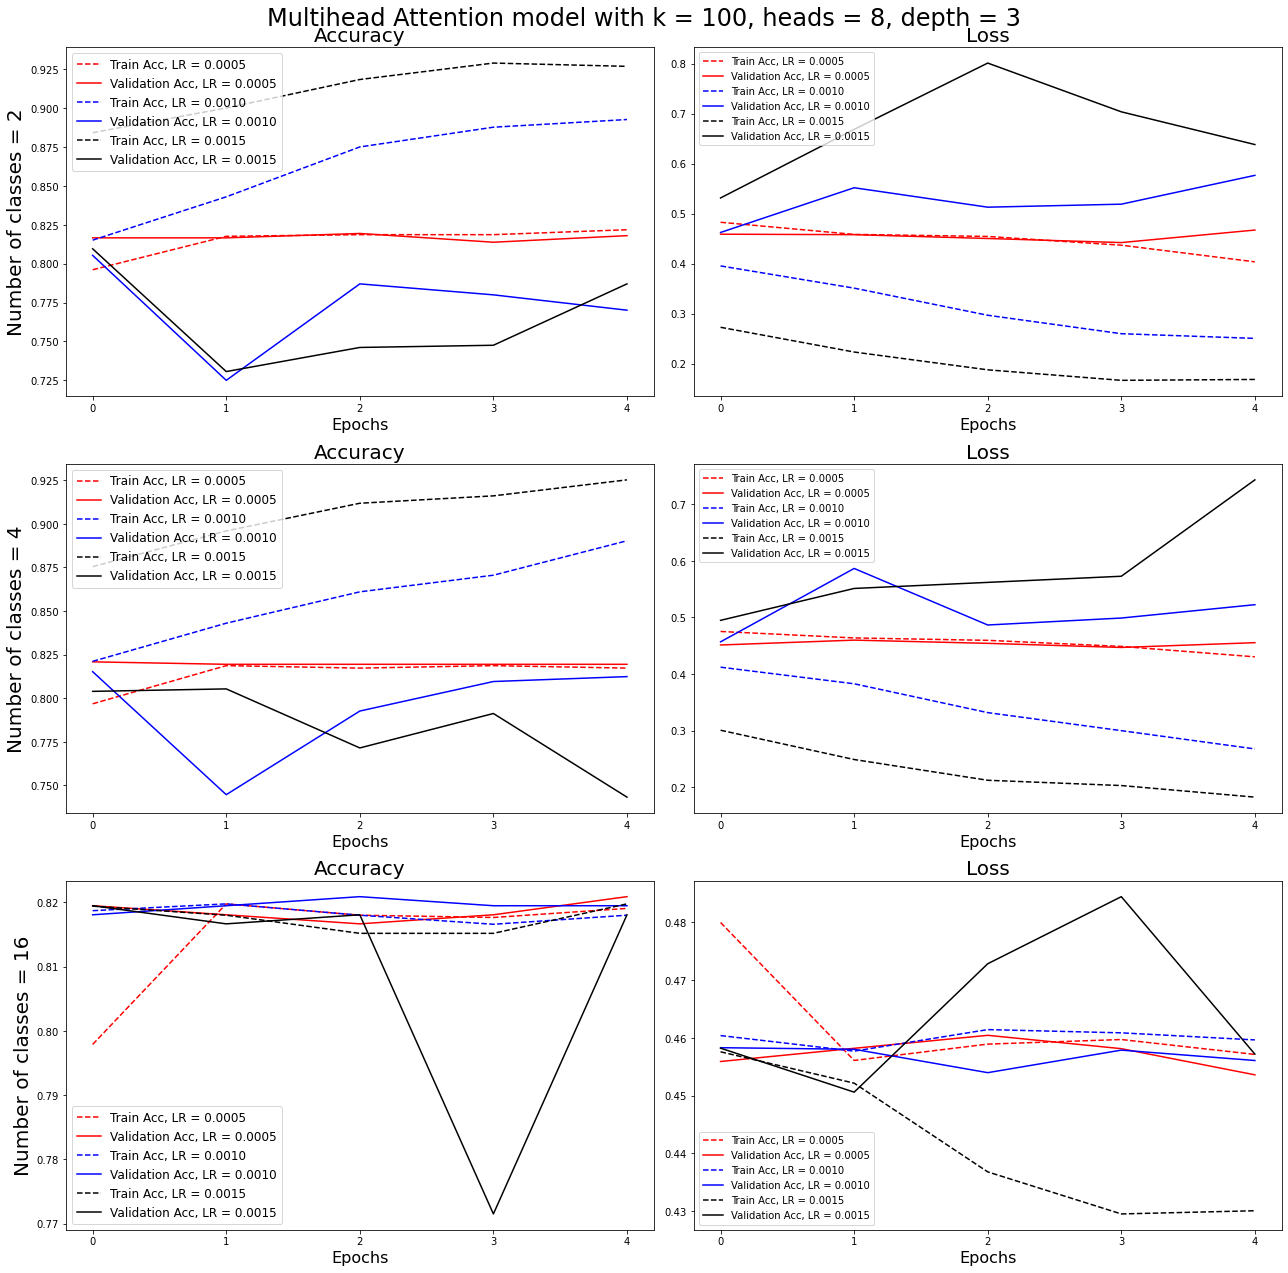

In [27]:
%%time
# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classess = [2,4,16]
k = 100
heads = 8
depth = 3
n_iter = 5
lrs = np.linspace(0.0005, 0.0015, 3)#define a range of learning rates


fig,ax = plt.subplots(3,2, figsize = (18, 18))
fig.suptitle('Multihead Attention model with k = %d, heads = %d, depth = %d'%(k, heads, depth), fontsize = 24)
for no, num_classes in enumerate(num_classess):
    model = Transformer(k, heads, depth, max_length, embedding_matrix, num_classes).to(device)

# Initialize built-in PyTorch Negative Log Likelihood loss function
    loss_fn = nn.BCELoss()

    epoch_tr_acc, epoch_vl_acc, epoch_tr_loss, epoch_vl_loss = train(model, loss_fn, 
                                                                     train_loader, n_iter, lrs,
                                                                     test_loader = valid_loader, 
                                                                     device = device)

#######################################################################################
# plot the results from the training and validation accuracies
    colors = ['red', 'blue', 'black', 'purple', 'green', 'brown']
    for i,e in enumerate(lrs):
        ax[no][0].plot(epoch_tr_acc[i], linestyle = '--', color = colors[i], label = 'Train Acc, LR = %.4f'%e)
        ax[no][0].plot(epoch_vl_acc[i], color = colors[i], label = 'Validation Acc, LR = %.4f'%e)
# plt.ylim([70, 80])
    ax[no][0].set_title("Accuracy", fontsize = 20)
    ax[no][0].set_xlabel('Epochs', fontsize = 16)
    ax[no][0].set_xticks([i for i in range(n_iter)])
    ax[no][0].set_ylabel('Number of classes = %d'%num_classes, fontsize = 20)
    ax[no][0].legend(prop = dict(size = 12))

    for i,e in enumerate(lrs):
        ax[no][1].plot(epoch_tr_loss[i], color = colors[i], linestyle = '--', label = 'Train Acc, LR = %.4f'%e)
        ax[no][1].plot(epoch_vl_loss[i], color = colors[i], label = 'Validation Acc, LR = %.4f'%e)
    ax[no][1].set_title("Loss", fontsize = 20)
    ax[no][1].set_xlabel('Epochs', fontsize = 16)
    ax[no][1].set_xticks([i for i in range(n_iter)])
    #ax[no][1].set_ylabel('Loss', fontsize = 20)
    ax[no][1].legend(prop = dict(size = 10))
plt.tight_layout()

Transformer(
  (embedding): Embedding(6001, 100)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttention(
        (to_keys): Linear(in_features=100, out_features=200, bias=False)
        (to_queries): Linear(in_features=100, out_features=200, bias=False)
        (to_values): Linear(in_features=100, out_features=200, bias=False)
        (unify_heads): Linear(in_features=200, out_features=100, bias=True)
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (norm_1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
      (norm_2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=100, out_features=200, bias=True)
        (1): ReLU()
        (2): Linear(in_features=200, out_features=100, bias=True)
      )
    )
    (1): TransformerBlock(
   

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Transformer(
  (embedding): Embedding(6001, 100)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttention(
        (to_keys): Linear(in_features=100, out_features=800, bias=False)
        (to_queries): Linear(in_features=100, out_features=800, bias=False)
        (to_values): Linear(in_features=100, out_features=800, bias=False)
        (unify_heads): Linear(in_features=800, out_features=100, bias=True)
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (norm_1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
      (norm_2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=100, out_features=200, bias=True)
        (1): ReLU()
        (2): Linear(in_features=200, out_features=100, bias=True)
      )
    )
    (1): TransformerBlock(
   

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Transformer(
  (embedding): Embedding(6001, 100)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttention(
        (to_keys): Linear(in_features=100, out_features=2000, bias=False)
        (to_queries): Linear(in_features=100, out_features=2000, bias=False)
        (to_values): Linear(in_features=100, out_features=2000, bias=False)
        (unify_heads): Linear(in_features=2000, out_features=100, bias=True)
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (norm_1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
      (norm_2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=100, out_features=200, bias=True)
        (1): ReLU()
        (2): Linear(in_features=200, out_features=100, bias=True)
      )
    )
    (1): TransformerBlock(

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

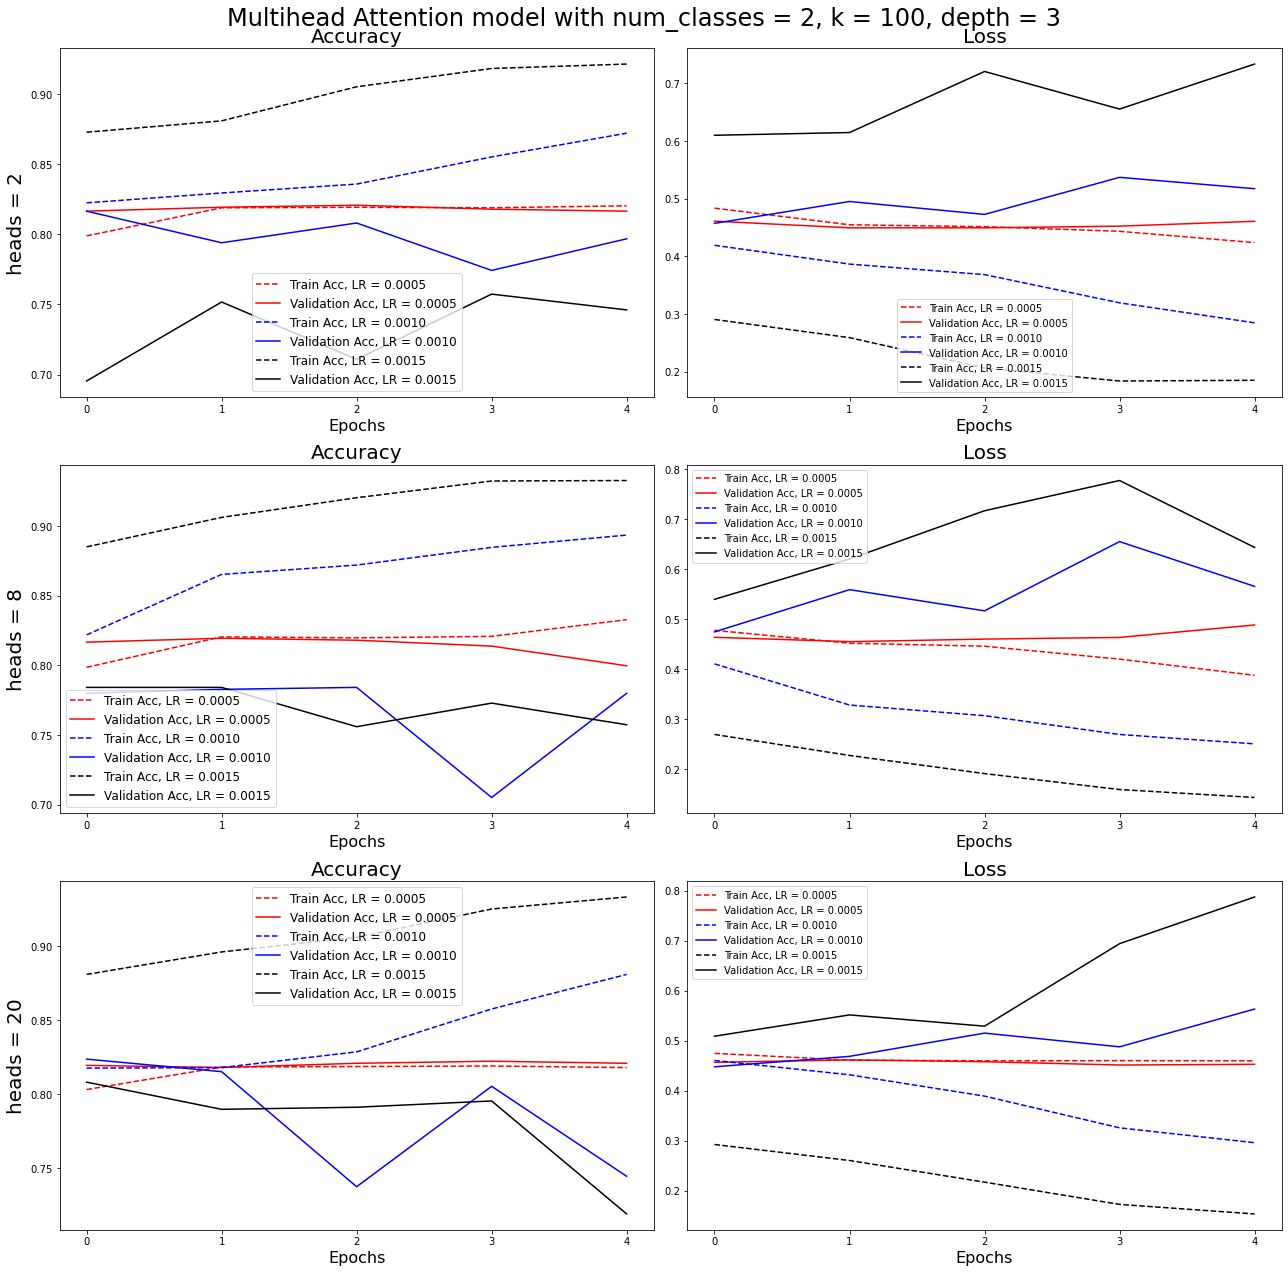

In [35]:
%%time
# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = 2
k = 100
headss = [2,8,20]
depth = 3
n_iter = 5
lrs = np.linspace(0.0005, 0.0015, 3)#define a range of learning rates


fig,ax = plt.subplots(3,2, figsize = (18, 18))
fig.suptitle('Multihead Attention model with num_classes = %d, k = %d, depth = %d'%(num_classes, k, depth), fontsize = 24)
for no, heads in enumerate(headss):
    model = Transformer(k, heads, depth, max_length,  embedding_matrix, num_classes).to(device)

# Initialize built-in PyTorch Negative Log Likelihood loss function
    loss_fn = nn.BCELoss()

    epoch_tr_acc, epoch_vl_acc, epoch_tr_loss, epoch_vl_loss = train(model, loss_fn, 
                                                                     train_loader, n_iter, lrs,
                                                                     test_loader = valid_loader, 
                                                                     device = device)

#######################################################################################
# plot the results from the training and validation accuracies
    colors = ['red', 'blue', 'black', 'purple', 'green', 'brown']
    for i,e in enumerate(lrs):
        ax[no][0].plot(epoch_tr_acc[i], linestyle = '--', color = colors[i], label = 'Train Acc, LR = %.4f'%e)
        ax[no][0].plot(epoch_vl_acc[i], color = colors[i], label = 'Validation Acc, LR = %.4f'%e)
# plt.ylim([70, 80])
    ax[no][0].set_title("Accuracy", fontsize = 20)
    ax[no][0].set_xlabel('Epochs', fontsize = 16)
    ax[no][0].set_xticks([i for i in range(n_iter)])
    ax[no][0].set_ylabel('heads = %d'%heads, fontsize = 20)
    ax[no][0].legend(prop = dict(size = 12))

    for i,e in enumerate(lrs):
        ax[no][1].plot(epoch_tr_loss[i], color = colors[i], linestyle = '--', label = 'Train Acc, LR = %.4f'%e)
        ax[no][1].plot(epoch_vl_loss[i], color = colors[i], label = 'Validation Acc, LR = %.4f'%e)
    ax[no][1].set_title("Loss", fontsize = 20)
    ax[no][1].set_xlabel('Epochs', fontsize = 16)
    ax[no][1].set_xticks([i for i in range(n_iter)])
    #ax[no][1].set_ylabel('Loss', fontsize = 20)
    ax[no][1].legend(prop = dict(size = 10))
plt.tight_layout()

Transformer(
  (embedding): Embedding(6001, 100)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttention(
        (to_keys): Linear(in_features=100, out_features=800, bias=False)
        (to_queries): Linear(in_features=100, out_features=800, bias=False)
        (to_values): Linear(in_features=100, out_features=800, bias=False)
        (unify_heads): Linear(in_features=800, out_features=100, bias=True)
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (norm_1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
      (norm_2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=100, out_features=200, bias=True)
        (1): ReLU()
        (2): Linear(in_features=200, out_features=100, bias=True)
      )
    )
    (1): TransformerBlock(
   

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Transformer(
  (embedding): Embedding(6001, 100)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttention(
        (to_keys): Linear(in_features=100, out_features=800, bias=False)
        (to_queries): Linear(in_features=100, out_features=800, bias=False)
        (to_values): Linear(in_features=100, out_features=800, bias=False)
        (unify_heads): Linear(in_features=800, out_features=100, bias=True)
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (norm_1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
      (norm_2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=100, out_features=200, bias=True)
        (1): ReLU()
        (2): Linear(in_features=200, out_features=100, bias=True)
      )
    )
    (1): TransformerBlock(
   

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Transformer(
  (embedding): Embedding(6001, 100)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttention(
        (to_keys): Linear(in_features=100, out_features=800, bias=False)
        (to_queries): Linear(in_features=100, out_features=800, bias=False)
        (to_values): Linear(in_features=100, out_features=800, bias=False)
        (unify_heads): Linear(in_features=800, out_features=100, bias=True)
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (norm_1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
      (norm_2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=100, out_features=200, bias=True)
        (1): ReLU()
        (2): Linear(in_features=200, out_features=100, bias=True)
      )
    )
    (1): TransformerBlock(
   

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

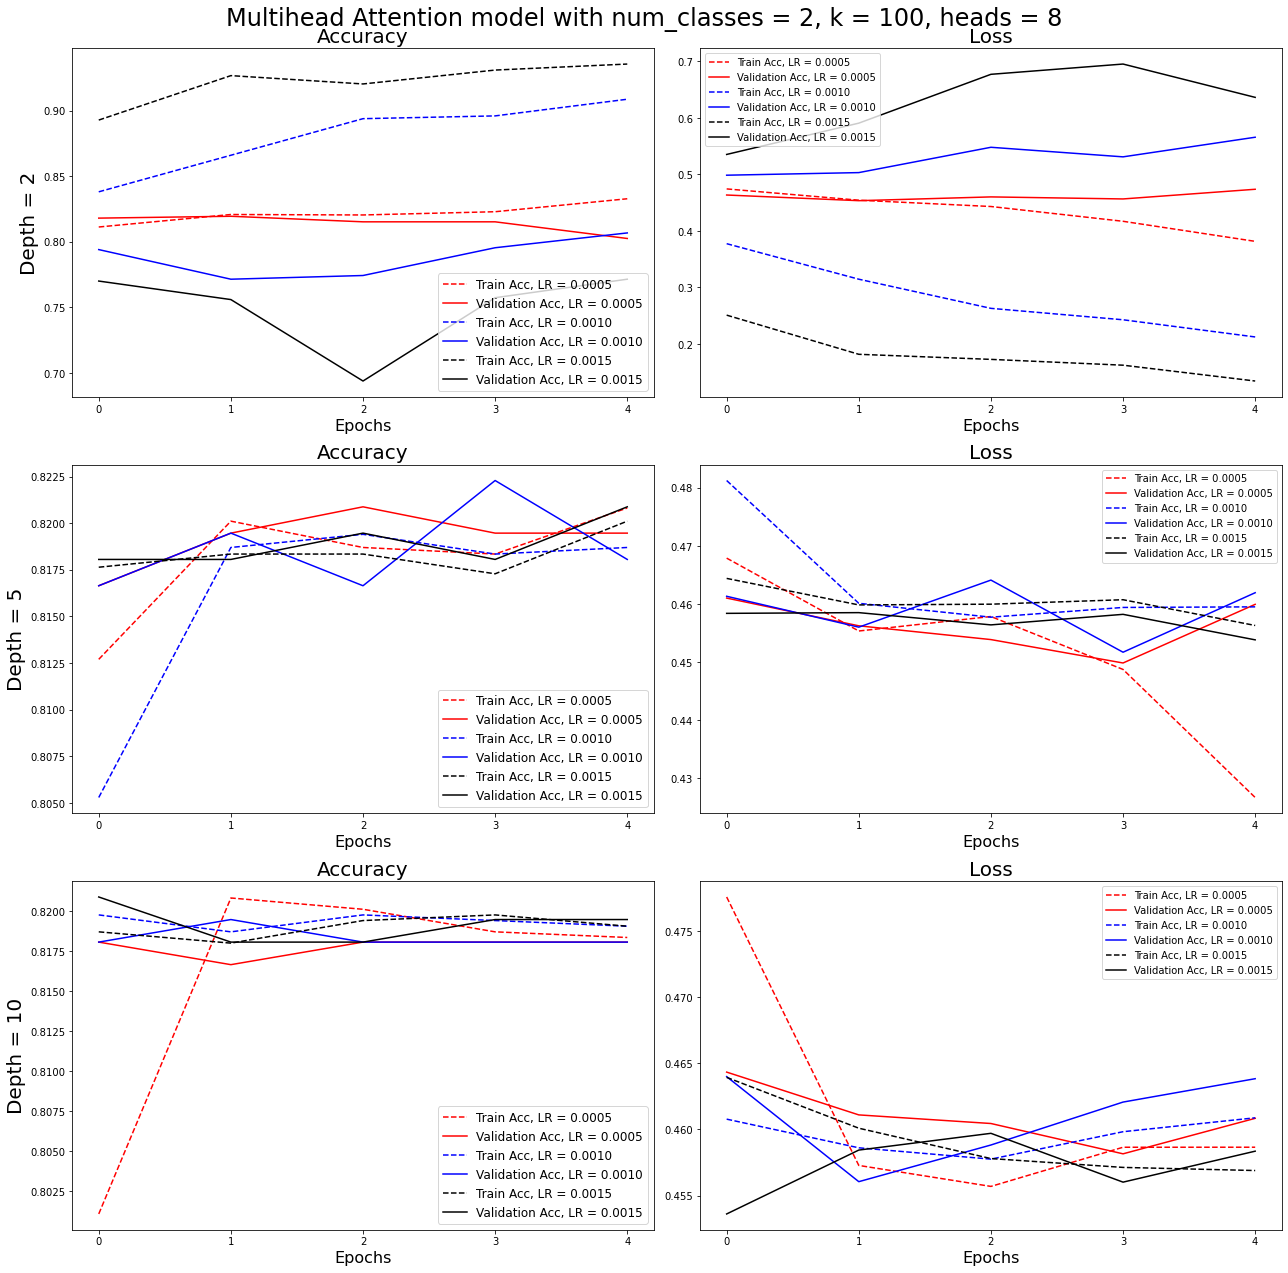

In [36]:
%%time
# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = 2
k = 100
heads = 8
depths = [2, 5, 10]
n_iter = 5
lrs = np.linspace(0.0005, 0.0015, 3)#define a range of learning rates


fig,ax = plt.subplots(3,2, figsize = (18, 18))
fig.suptitle('Multihead Attention model with num_classes = %d, k = %d, heads = %d'%(num_classes, k, heads), fontsize = 24)
for no, depth in enumerate(depths):
    model = Transformer(k, heads, depth, max_length, embedding_matrix, num_classes).to(device)

# Initialize built-in PyTorch Negative Log Likelihood loss function
    loss_fn = nn.BCELoss()

    epoch_tr_acc, epoch_vl_acc, epoch_tr_loss, epoch_vl_loss = train(model, loss_fn, 
                                                                     train_loader, n_iter, lrs,
                                                                     test_loader = valid_loader, 
                                                                     device = device)

#######################################################################################
# plot the results from the training and validation accuracies
    colors = ['red', 'blue', 'black', 'purple', 'green', 'brown']
    for i,e in enumerate(lrs):
        ax[no][0].plot(epoch_tr_acc[i], linestyle = '--', color = colors[i], label = 'Train Acc, LR = %.4f'%e)
        ax[no][0].plot(epoch_vl_acc[i], color = colors[i], label = 'Validation Acc, LR = %.4f'%e)
# plt.ylim([70, 80])
    ax[no][0].set_title("Accuracy", fontsize = 20)
    ax[no][0].set_xlabel('Epochs', fontsize = 16)
    ax[no][0].set_xticks([i for i in range(n_iter)])
    ax[no][0].set_ylabel('Depth = %d'%depth, fontsize = 20)
    ax[no][0].legend(prop = dict(size = 12))

    for i,e in enumerate(lrs):
        ax[no][1].plot(epoch_tr_loss[i], color = colors[i], linestyle = '--', label = 'Train Acc, LR = %.4f'%e)
        ax[no][1].plot(epoch_vl_loss[i], color = colors[i], label = 'Validation Acc, LR = %.4f'%e)
    ax[no][1].set_title("Loss", fontsize = 20)
    ax[no][1].set_xlabel('Epochs', fontsize = 16)
    ax[no][1].set_xticks([i for i in range(n_iter)])
    #ax[no][1].set_ylabel('Loss', fontsize = 20)
    ax[no][1].legend(prop = dict(size = 10))
plt.tight_layout()

# Training the model with optimal parameters on iSarcasm

Transformer(
  (embedding): Embedding(6001, 100)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttention(
        (to_keys): Linear(in_features=100, out_features=400, bias=False)
        (to_queries): Linear(in_features=100, out_features=400, bias=False)
        (to_values): Linear(in_features=100, out_features=400, bias=False)
        (unify_heads): Linear(in_features=400, out_features=100, bias=True)
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (norm_1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
      (norm_2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=100, out_features=200, bias=True)
        (1): ReLU()
        (2): Linear(in_features=200, out_features=100, bias=True)
      )
    )
    (1): TransformerBlock(
   

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

CPU times: user 5min 41s, sys: 3min 24s, total: 9min 6s
Wall time: 4min 59s


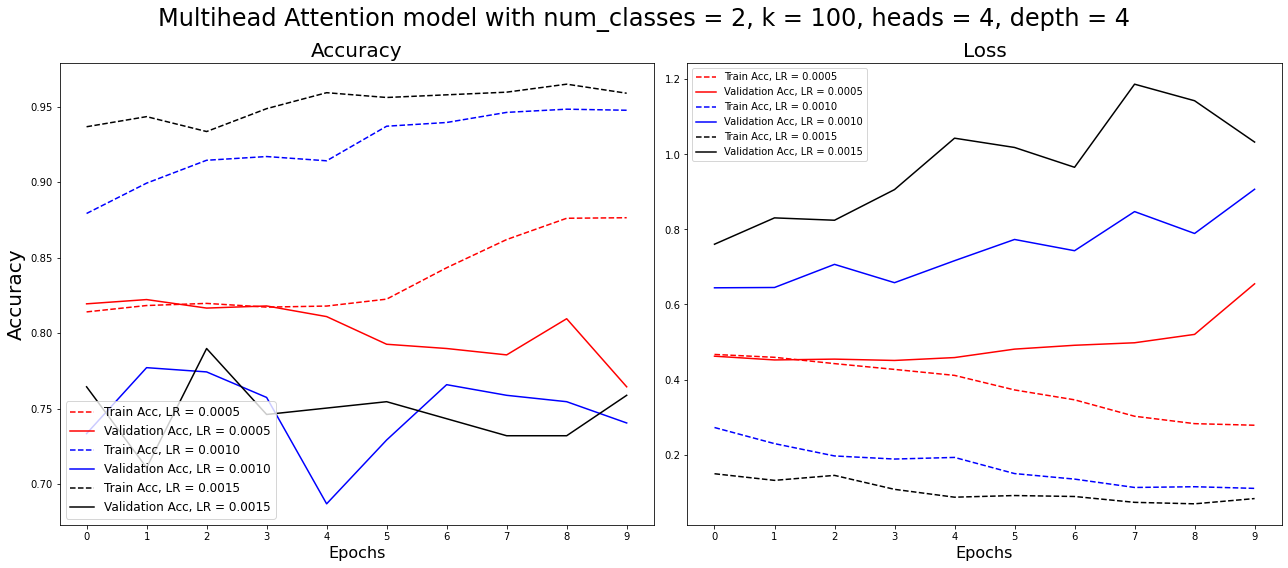

In [41]:
%%time
# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## optimal parameters
num_classes = 2
k = 100
heads = 4
depth = 4
n_iter = 10

lrs = np.linspace(0.0005, 0.0015, 3)#define a range of learning rates


fig,ax = plt.subplots(1,2, figsize = (18, 8))
fig.suptitle('Multihead Attention model with num_classes = %d, k = %d, heads = %d, depth = %d'%(num_classes, k, heads, depth), fontsize = 24)
model = Transformer(k, heads, depth, max_length, embedding_matrix, num_classes).to(device)

# Initialize built-in PyTorch Negative Log Likelihood loss function
loss_fn = nn.BCELoss()

epoch_tr_acc, epoch_vl_acc, epoch_tr_loss, epoch_vl_loss = train(model, loss_fn, 
                                                                     train_loader, n_iter, lrs,
                                                                     test_loader = valid_loader, 
                                                                     device = device)

#######################################################################################
# plot the results from the training and validation accuracies
colors = ['red', 'blue', 'black', 'purple', 'green', 'brown']
for i,e in enumerate(lrs):
    ax[0].plot(epoch_tr_acc[i], linestyle = '--', color = colors[i], label = 'Train Acc, LR = %.4f'%e)
    ax[0].plot(epoch_vl_acc[i], color = colors[i], label = 'Validation Acc, LR = %.4f'%e)
# plt.ylim([70, 80])
ax[0].set_title("Accuracy", fontsize = 20)
ax[0].set_xlabel('Epochs', fontsize = 16)
ax[0].set_xticks([i for i in range(n_iter)])
ax[0].set_ylabel('Accuracy', fontsize = 20)
ax[0].legend(prop = dict(size = 12))

for i,e in enumerate(lrs):
    ax[1].plot(epoch_tr_loss[i], color = colors[i], linestyle = '--', label = 'Train Acc, LR = %.4f'%e)
    ax[1].plot(epoch_vl_loss[i], color = colors[i], label = 'Validation Acc, LR = %.4f'%e)
ax[1].set_title("Loss", fontsize = 20)
ax[1].set_xlabel('Epochs', fontsize = 16)
ax[1].set_xticks([i for i in range(n_iter)])
    #ax[no][1].set_ylabel('Loss', fontsize = 20)
ax[1].legend(prop = dict(size = 10))
plt.tight_layout()

# Pickle the model trainedd on iSarcasm

In [45]:
# # Let us use the Pickle library to save the model.
import pickle
with open('/Users/bengieru/Desktop/NMA-DL/iSarcasm/iSarcasm_dataset/pickled_model_isarcasm.pk', 'wb') as file:
    pickle.dump(model, file)

# Load your test data here

#  Load your model you've trained on whatever dataset (isarcasm, mergeddata, sentiment140) here

In [44]:
with open('/Users/bengieru/Desktop/NMA-DL/iSarcasm/iSarcasm_dataset/pickled_model_isarcasm.pk', 'rb') as file:
    model = pickle.load(file)

# test on the model

In [ ]:
#######################################################################################
# Lists to follow the evolution of the loss and accuracy
test_losses = []
model.eval()
test_acc = 0.0
for j, test_batch in enumerate(test_loader):
    out_test = model(test_batch[0].to(device))
    labels_test = test_batch[1].to(device)
    test_loss = loss_fn(out_test.squeeze(), labels_test.float())
                
                #val_loss = criterion(out_test.squeeze(), test_batch[1].float())

    test_losses.append(test_loss.item())

    accuracy = acc(out_test, test_batch[1].to(device))
    test_acc += accuracy